In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# read the data from txt
df= pd.read_table('datasets-v3_1/task-1/task1.train.txt', header= None)

In [3]:
df.columns = ['text', 'id', 'label']
df.set_index('id', inplace= True)

In [4]:
df[:3]

,text,label
id,,
727600136,"Et tu, Rhody? A recent editorial in the Provi...",non-propaganda
731714618,A recent post in The Farmington Mirror — our t...,non-propaganda
731714635,"President Donald Trump, as he often does while...",non-propaganda


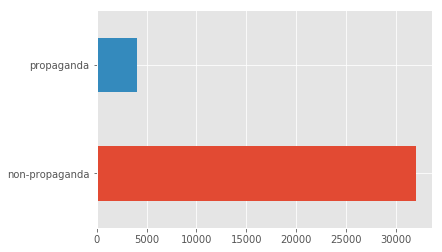

In [5]:
df['label'].value_counts().plot(kind='barh')

In [6]:
df['label']= df['label'].map({'propaganda':1, 'non-propaganda':0})

## Text Processing

cleaning the data using spacy

In [11]:
import string
import re
import spacy
import pickle
npl= spacy.load('en')

In [110]:
# don't run this code! use the pickle
def t_cleaner(text):
    tokens = npl(text)
    lemmas = []
    for t in tokens:
        if t.is_punct or t.is_space or t.like_num or t.like_url:
            pass
        else:
            lemmas.append(t.lemma_.lower().strip() if t.lemma_ != "-PRON-" else t.lower_)
    joined = ' '.join(lemmas)
    corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return corrected

In [13]:
%timeit df['text'].iloc[:10].apply(t_tokenizer)

2.8 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print('Total time {0:.2f}h'.format((2.8 * df.shape[0]/10)/3600))

Total time 2.80h


In [17]:
df['text_clean']= df['text'].apply(t_cleaner)
# dump to picle
df.to_pickle('cleaned.pkl')

## Text Analysis

In [7]:
# start importing here
df= pd.read_pickle('cleaned.pkl')

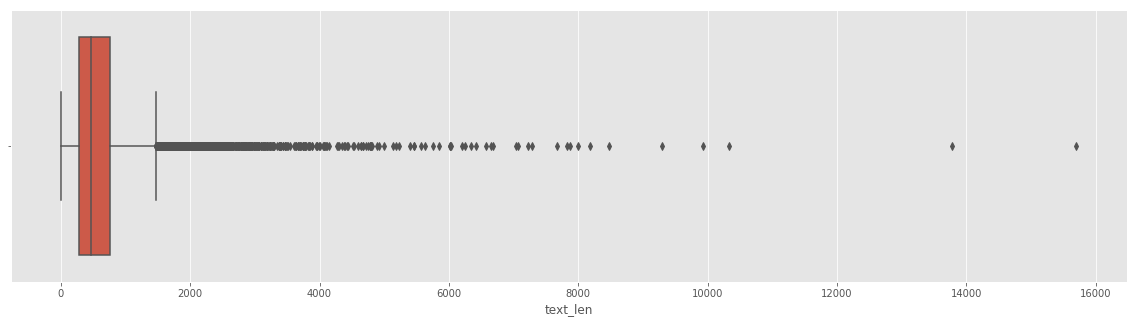

In [8]:
# Visualize words count distribution

df['text_len'] = df['text_clean'].apply(lambda words: len(words.split(" ")))

plt.figure(figsize=(20, 5))
sns.boxplot(x= df['text_len'], orient= 'h')


In [18]:
max_features=6000

Comparing text and cleanded text for document 0

In [19]:
df['text'].iloc[0]

'הכתבה החשובה של @Ofer_Hadad במלואה. אלימות ברוטלית נגד קטין בחסות סיור של שוברים שתיקה @btsIsrael. אל תתנו לזה לעבור בשקט >> pic.twitter.com/nTfrqGwgU4 — ישראל שלי | MyIsrael (@MyIsraelorgil) July 12, 2018  If you\'ve ever encountered a peace activist, you know that they\'re anything but peaceful. That\'s especially the case with the crews that converge on Israel.  An observer who took part in a tour of the Breaking the Silence organization in Tel Rumeida in Hevron slapped a 10-year-old Jewish boy. In the documentation published in News 2, the man, a representative of the multinational group Temporary International Presence in Hebron (TIPH), appeared to be slapping a child who approached the group. The police arrested the activist on suspicion of assaulting a minor. He was released under restrictive conditions after being questioned  Breaking the Silence issued a predictably despicable statement. The Swiss ambassador offered another non-apology which appeared to blame it on the 10-yea

In [20]:
df['text_clean'].iloc[0] #check why \'s wasn't removed, try to clean it if rerun

"הכתבה החשובה של @ofer_hadad במלואה אלימות ברוטלית נגד קטין בחסות סיור של שוברים שתיקה @btsisrael אל תתנו לזה לעבור בשקט > > pic.twitter.com/ntfrqgwgu4 ישראל שלי | myisrael @myisraelorgil july if you have ever encounter a peace activist you know that they be anything but peaceful that be especially the case with the crew that converge on israel an observer who take part in a tour of the breaking the silence organization in tel rumeida in hevron slap a 10-year old jewish boy in the documentation publish in news the man a representative of the multinational group temporary international presence in hebron tiph appear to be slap a child who approach the group the police arrest the activist on suspicion of assault a minor he be release under restrictive condition after be question break the silence issue a predictably despicable statement the swiss ambassador offer another non apology which appear to blame it on the 10-year old on friday the swiss ambassador to israel jean daniel ruch pen 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [22]:
# shuffle so not 1 and 0 are mixed
df= shuffle(df)
df[:5]

,text,label,text_clean,text_len
id,,,,
727354042,Timothy Piazza's death last year after attendi...,0,timothy piazza 's death last year after attend...,1040
727619364,DONALD Trump’s administration has made an emba...,0,donald trump ’s administration have make an em...,630
752616222,About 72% of students qualified in the enginee...,0,about of student qualify in the engineering ex...,352
730966425,THE value of leading cryptocurrencies soared o...,0,the value of lead cryptocurrencie soar on wedn...,578
755584009,"For many years, Israel faced the danger of a n...",0,for many year israel face the danger of a nucl...,757


In [23]:
# splitting the data in test and train
X_train, X_test, y_train, y_test= train_test_split(df['text_clean'], df['label'],
                                                   test_size= 0.25, random_state= 1234)

### test different calssifiers

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier # too long try to rerun
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC too long to compute
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2

In [49]:
classifiers = [
    ('LogisticRegression', LogisticRegression()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('Kneighbors', KNeighborsClassifier(2)),
    #('SVC', SVC(probability=True)),
    ('MPL', MLPClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('GradientBoosting', GradientBoostingClassifier())]
results=[]

tf_vectorizer= TfidfVectorizer(max_features= max_features, stop_words= 'english')

for c in classifiers: 
    clf= Pipeline([('tvect', tf_vectorizer),
                   ('sel', SelectKBest(chi2, k=2000)),
                   ('clf', c[1])])
    print(f'Fitting {c[0]} classifier...')
    clf.fit(X_train, y_train)
    print('Predicting...')
    y_pred= clf.predict(X_test)
    results.append((c[0], f1_score(y_test, y_pred), y_pred))

Fitting LogisticRegression classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Predicting...
Fitting DecisionTree classifier...
Predicting...
Fitting RandomForest classifier...


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicting...
Fitting Kneighbors classifier...
Predicting...
Fitting MPL classifier...
Predicting...
Fitting AdaBoost classifier...
Predicting...
Fitting GradientBoosting classifier...
Predicting...


Text(0.5, 0, 'f1 score')

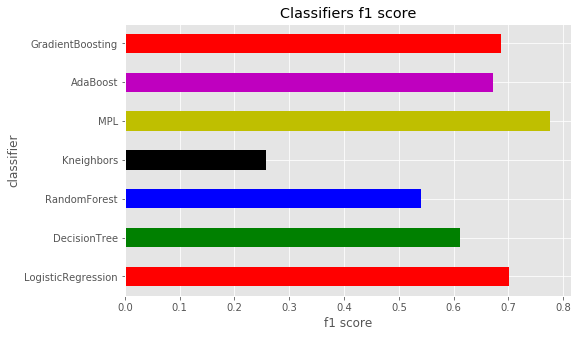

In [28]:
results= pd.DataFrame(results, columns=['classifier', 'f1_score', 'results'])
results[['classifier', 'f1_score']].set_index('classifier').plot(kind='barh',
                                                                 color= 'rgbkymc', legend=None, figsize=(8,5))
plt.title('Classifiers f1 score')
plt.xlabel('f1 score')

In [30]:
results[['classifier', 'f1_score']]

,classifier,f1_score
0,LogisticRegression,0.700438
1,DecisionTree,0.610942
2,RandomForest,0.539683
3,Kneighbors,0.256722
4,MPL,0.775681
5,AdaBoost,0.672122
6,GradientBoosting,0.685824


## AdaBoost

### Logistic regression

In [39]:
lr_param_grid = dict(
    tvect__use_idf= [True, False],
    tvect__ngram_range= [(1,1), (1,2), (1,3)],
    clf__C= [ 1e2, 1e3, 1e4, 1e5],
    clf__class_weight= [None, 'balanced']
    )

In [55]:
lr_clf= Pipeline([
    ('tvect', TfidfVectorizer( ngram_range= (1,2),
                              stop_words= 'english', lowercase= False)),
    ('sel', SelectKBest(chi2, k=1000)),
    ('clf', LogisticRegression(max_iter= 200, class_weight= 'balanced', C= 1e5))])

In [56]:
lr_random_search= RandomizedSearchCV(lr_clf, param_distributions= lr_param_grid,
                                    scoring= 'f1', n_iter=5, n_jobs=-1, cv=3)

In [57]:
lr_clf.fit(X_train,y_train)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('tvect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [58]:
lr_y_pred= lr_clf.predict(X_test)

In [59]:
f1_score(y_test, lr_y_pred)

0.7092436974789915